In [3]:
import os
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt


In [4]:
print("CWD:", os.getcwd())
print("Folders:", os.listdir())


CWD: C:\Users\Dana\PhishingProjectV2
Folders: ['.ipynb_checkpoints', 'data', 'diagrams', 'Full Project Summary.docx', 'main_pipeline.ipynb', 'models', 'README.md', 'splits', '~$ll Project Summary.docx']


In [5]:
import pandas as pd

df = pd.read_csv("splits/labels.csv")

print("✅ Loaded labels.csv")
print("Shape:", df.shape)
print(df["class"].value_counts())
df.head()


✅ Loaded labels.csv
Shape: (1697, 3)
class
benign      1147
phishing     550
Name: count, dtype: int64


,filepath,label,class
0,data/benign/genuine_movies-on-demand.tvwatch_s...,0,benign
1,data/benign/genuine_autopartswarehouse.comdeta...,0,benign
2,data/benign/genuine_bestplaces.netcityohioclev...,0,benign
3,data/benign/genuine_facebook.comfkulan_2739.png,0,benign
4,data/phishing/phishing_likelikeblog.bugs3.comk...,1,phishing


In [6]:
import os
#verifying
missing = df[~df["filepath"].apply(os.path.exists)]
print("❌ Missing images:", len(missing))

if len(missing) > 0:
    print(missing.head(10))


❌ Missing images: 0


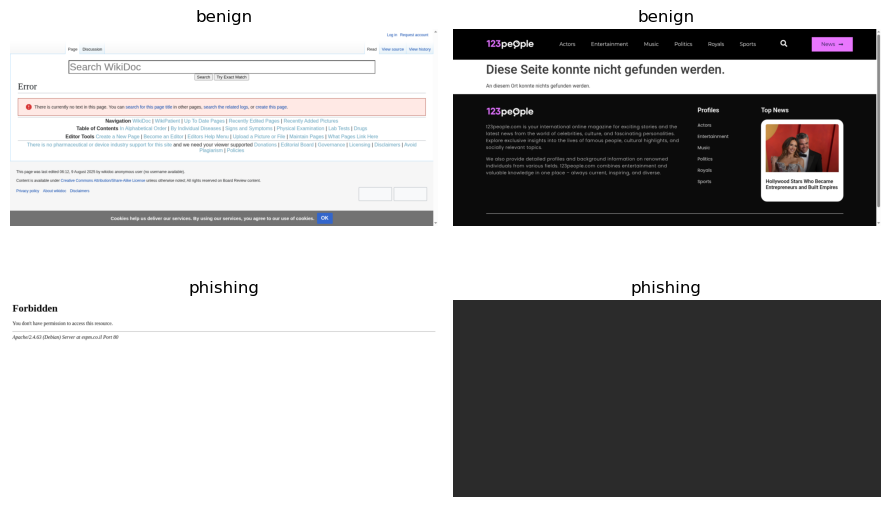

In [7]:
import matplotlib.pyplot as plt
from PIL import Image
#visualization
samples = df.groupby("class").sample(2, random_state=42)

fig, axes = plt.subplots(2, 2, figsize=(9,6))
axes = axes.flatten()

for ax, (_, row) in zip(axes, samples.iterrows()):
    img = Image.open(row["filepath"]).convert("RGB")
    ax.imshow(img)
    ax.set_title(row["class"])
    ax.axis("off")

plt.tight_layout()
plt.show()


In [8]:
from sklearn.model_selection import train_test_split
import os

SEED = 42
TRAIN_RATIO, VAL_RATIO, TEST_RATIO = 0.7, 0.15, 0.15

train_df, temp_df = train_test_split(
    df,
    test_size=(1 - TRAIN_RATIO),
    random_state=SEED,
    stratify=df["label"]
)

val_ratio_of_temp = VAL_RATIO / (VAL_RATIO + TEST_RATIO)

val_df, test_df = train_test_split(
    temp_df,
    test_size=(1 - val_ratio_of_temp),
    random_state=SEED,
    stratify=temp_df["label"]
)

# שמירה
os.makedirs("splits", exist_ok=True)
train_df.to_csv("splits/train_labels.csv", index=False)
val_df.to_csv("splits/val_labels.csv", index=False)
test_df.to_csv("splits/test_labels.csv", index=False)

print("✅ Saved splits!")
print("Train:", train_df["class"].value_counts().to_dict())
print("Val:", val_df["class"].value_counts().to_dict())
print("Test:", test_df["class"].value_counts().to_dict())


✅ Saved splits!
Train: {'benign': 802, 'phishing': 385}
Val: {'benign': 172, 'phishing': 83}
Test: {'benign': 173, 'phishing': 82}


class
benign      1147
phishing     550
Name: count, dtype: int64


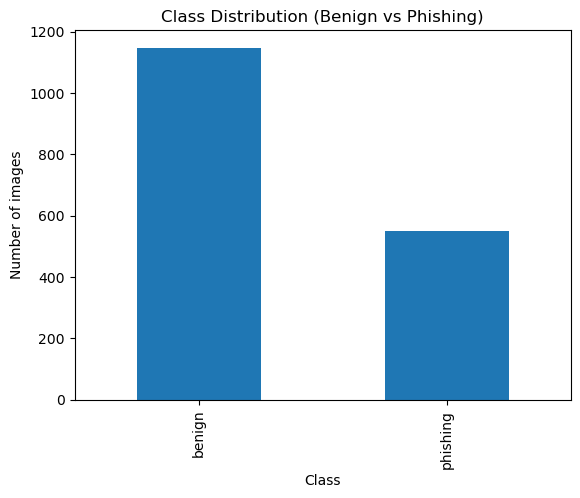

In [9]:
import matplotlib.pyplot as plt

counts = df["class"].value_counts()
print(counts)

counts.plot(kind="bar")
plt.title("Class Distribution (Benign vs Phishing)")
plt.xlabel("Class")
plt.ylabel("Number of images")
plt.show()


        width      height
count   200.0  200.000000
mean   1366.0  631.080000
std       0.0   10.215448
min    1366.0  629.000000
25%    1366.0  629.000000
50%    1366.0  629.000000
75%    1366.0  629.000000
max    1366.0  681.000000


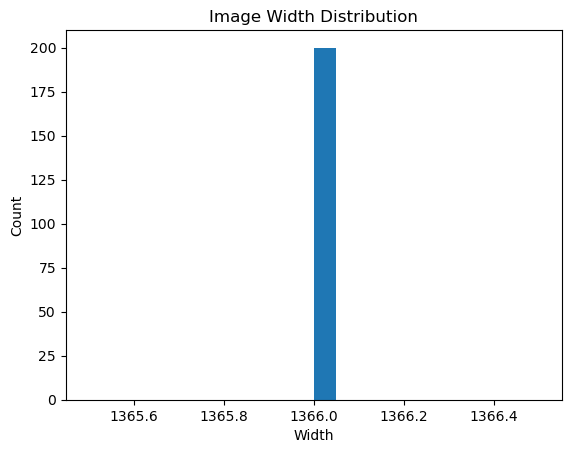

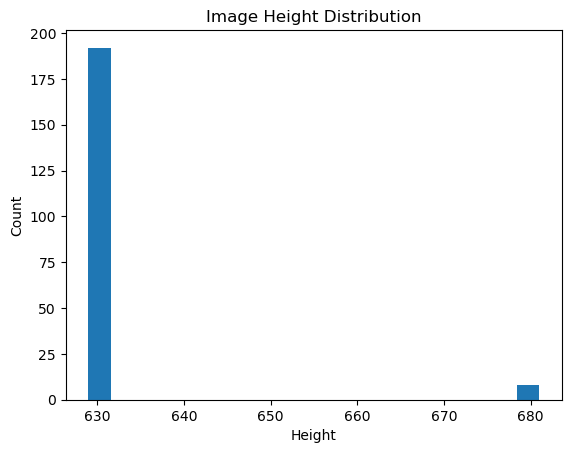

In [10]:
from PIL import Image
import pandas as pd

sample_df = df.sample(200, random_state=42).copy()  

widths, heights = [], []

for p in sample_df["filepath"]:
    img = Image.open(p)
    w, h = img.size
    widths.append(w)
    heights.append(h)

sample_df["width"] = widths
sample_df["height"] = heights

print(sample_df[["width", "height"]].describe())

plt.hist(sample_df["width"], bins=20)
plt.title("Image Width Distribution")
plt.xlabel("Width")
plt.ylabel("Count")
plt.show()

plt.hist(sample_df["height"], bins=20)
plt.title("Image Height Distribution")
plt.xlabel("Height")
plt.ylabel("Count")
plt.show()


In [11]:
import os
import time
import numpy as np
import pandas as pd

from PIL import Image
import matplotlib.pyplot as plt

from sklearn.metrics import (
    confusion_matrix, classification_report,
    precision_score, recall_score, f1_score, accuracy_score
)

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as T
from torchvision import models


In [12]:
train_df = pd.read_csv("splits/train_labels.csv")
val_df   = pd.read_csv("splits/val_labels.csv")
test_df  = pd.read_csv("splits/test_labels.csv")

print("Train:", train_df.shape, train_df["class"].value_counts().to_dict())
print("Val:",   val_df.shape,   val_df["class"].value_counts().to_dict())
print("Test:",  test_df.shape,  test_df["class"].value_counts().to_dict())


Train: (1187, 3) {'benign': 802, 'phishing': 385}
Val: (255, 3) {'benign': 172, 'phishing': 83}
Test: (255, 3) {'benign': 173, 'phishing': 82}


In [13]:
class PhishingImageDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df.reset_index(drop=True)
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img = Image.open(row["filepath"]).convert("RGB")
        label = int(row["label"])

        if self.transform:
            img = self.transform(img)

        return img, label


train_tf = T.Compose([
    T.Resize((224, 224)),
    T.RandomHorizontalFlip(p=0.2),
    T.ToTensor(),
])

eval_tf = T.Compose([
    T.Resize((224, 224)),
    T.ToTensor(),
])


In [14]:
BATCH_SIZE = 16  
NUM_WORKERS = 0  

train_ds = PhishingImageDataset(train_df, transform=train_tf)
val_ds   = PhishingImageDataset(val_df,   transform=eval_tf)
test_ds  = PhishingImageDataset(test_df,  transform=eval_tf)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True,  num_workers=NUM_WORKERS)
val_loader   = DataLoader(val_ds,   batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)
test_loader  = DataLoader(test_ds,  batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)

print("✅ Loaders ready")


✅ Loaders ready


In [15]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("DEVICE:", DEVICE)

# ResNet18 
model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
model.fc = nn.Linear(model.fc.in_features, 2)
model = model.to(DEVICE)

#fine-tuning implemention
for param in model.parameters():
    param.requires_grad = False


for param in model.fc.parameters():
    param.requires_grad = True


counts = train_df["label"].value_counts().to_dict()
w0 = 1.0 / counts.get(0, 1)
w1 = 1.0 / counts.get(1, 1)
class_weights = torch.tensor([w0, w1], dtype=torch.float32).to(DEVICE)

criterion = nn.CrossEntropyLoss(weight=class_weights)

optimizer = torch.optim.Adam(model.fc.parameters(), lr=1e-3)

print("✅ Fine-tuning mode: training ONLY model.fc")
print("✅ Class weights:", class_weights.detach().cpu().numpy())


DEVICE: cpu
✅ Fine-tuning mode: training ONLY model.fc
✅ Class weights: [0.00124688 0.0025974 ]


In [16]:
trainable = sum(p.numel() for p in model.parameters() if p.requires_grad)
total = sum(p.numel() for p in model.parameters())
print(f"Trainable params: {trainable:,} / {total:,}")


Trainable params: 1,026 / 11,177,538


In [17]:
def run_epoch(model, loader, train=True):
    model.train() if train else model.eval()
#training loop
    total_loss = 0.0
    all_preds = []
    all_labels = []

    with torch.set_grad_enabled(train):
        for imgs, labels in loader:
            imgs = imgs.to(DEVICE)
            labels = labels.to(DEVICE)

            logits = model(imgs)
            loss = criterion(logits, labels)

            if train:
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

            total_loss += loss.item() * imgs.size(0)
            preds = torch.argmax(logits, dim=1)

            all_preds.extend(preds.detach().cpu().numpy().tolist())
            all_labels.extend(labels.detach().cpu().numpy().tolist())

    avg_loss = total_loss / len(loader.dataset)
    acc = accuracy_score(all_labels, all_preds)
    return avg_loss, acc

def train_model(epochs=2):
    for ep in range(1, epochs + 1):
        t0 = time.time()
        tr_loss, tr_acc = run_epoch(model, train_loader, train=True)
        va_loss, va_acc = run_epoch(model, val_loader, train=False)
        print(f"Epoch {ep}/{epochs} | train loss={tr_loss:.4f} acc={tr_acc:.4f} | val loss={va_loss:.4f} acc={va_acc:.4f} | time={time.time()-t0:.1f}s")


In [18]:
train_model(epochs=2)


Epoch 1/2 | train loss=0.6848 acc=0.6108 | val loss=0.6157 acc=0.6314 | time=191.0s
Epoch 2/2 | train loss=0.6328 acc=0.6403 | val loss=0.6198 acc=0.6745 | time=177.6s


In [19]:
def predict(model, loader):
    model.eval()
    all_probs = []
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for imgs, labels in loader:
            imgs = imgs.to(DEVICE)
            logits = model(imgs)
            probs = torch.softmax(logits, dim=1)[:, 1]  
            preds = (probs >= 0.5).long()

            all_probs.extend(probs.detach().cpu().numpy().tolist())
            all_preds.extend(preds.detach().cpu().numpy().tolist())
            all_labels.extend(labels.numpy().tolist())

    return np.array(all_labels), np.array(all_preds), np.array(all_probs)

y_true, y_pred, y_prob = predict(model, test_loader)

print("Accuracy:", accuracy_score(y_true, y_pred))
print("Precision:", precision_score(y_true, y_pred))
print("Recall:", recall_score(y_true, y_pred))
print("F1:", f1_score(y_true, y_pred))
print("\nClassification Report:\n", classification_report(y_true, y_pred, target_names=["benign", "phishing"]))

cm = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:\n", cm)


Accuracy: 0.7294117647058823
Precision: 0.5698924731182796
Recall: 0.6463414634146342
F1: 0.6057142857142858

Classification Report:
               precision    recall  f1-score   support

      benign       0.82      0.77      0.79       173
    phishing       0.57      0.65      0.61        82

    accuracy                           0.73       255
   macro avg       0.70      0.71      0.70       255
weighted avg       0.74      0.73      0.73       255

Confusion Matrix:
 [[133  40]
 [ 29  53]]


In [20]:
os.makedirs("models", exist_ok=True)
torch.save(model.state_dict(), "models/resnet18_phishing.pt")
print("✅ Saved: models/resnet18_phishing.pt")


✅ Saved: models/resnet18_phishing.pt


In [21]:
from dataclasses import dataclass, field
from typing import List, Dict

@dataclass
class Message:
    filepath: str
    true_label: int = -1
    prob_phishing: float = 0.0
    pred_label: int = 0
    decision: str = "allow"
    notes: List[str] = field(default_factory=list)

def preprocess_image(path):
    img = Image.open(path).convert("RGB")
    img = eval_tf(img).unsqueeze(0)  
    return img

def inference_stage(msgs: List[Message], model, threshold=0.5):
    model.eval()
    out = []
    with torch.no_grad():
        for m in msgs:
            x = preprocess_image(m.filepath).to(DEVICE)
            logits = model(x)
            prob = torch.softmax(logits, dim=1)[0, 1].item()
            m.prob_phishing = prob
            m.pred_label = 1 if prob >= threshold else 0
            out.append(m)
    return out

def fingerprinting_stage(msgs: List[Message]):
    out = []
    for m in msgs:
        name = os.path.basename(m.filepath).lower()
        if "login" in name or "bank" in name or "verify" in name:
            m.notes.append("filename suggests credential theme")
        out.append(m)
    return out

def decision_stage(msgs: List[Message]):
    out = []
    for m in msgs:
        if m.pred_label == 1:
            m.decision = "block"
        else:
            m.decision = "allow"
        out.append(m)
    return out

def run_pipeline(csv_path, model, threshold=0.2, limit=200):
    df_local = pd.read_csv(csv_path).head(limit)
    msgs = [Message(filepath=row["filepath"], true_label=int(row["label"])) for _, row in df_local.iterrows()]

    msgs = inference_stage(msgs, model, threshold=threshold)
    msgs = fingerprinting_stage(msgs)
    msgs = decision_stage(msgs)

    # Output table
    out_df = pd.DataFrame([{
        "filepath": m.filepath,
        "true_label": m.true_label,
        "pred_label": m.pred_label,
        "prob_phishing": round(m.prob_phishing, 4),
        "decision": m.decision,
        "notes": "; ".join(m.notes)
    } for m in msgs])

    return out_df

pipeline_out = run_pipeline("splits/test_labels.csv", model, threshold=0.2, limit=200)
pipeline_out.head(10)


,filepath,true_label,pred_label,prob_phishing,decision,notes
0,data/benign/genuine_sports790.compagesglenndav...,0,1,0.6413,block,
1,data/benign/genuine_philscoins.com_804.png,0,0,0.1001,allow,
2,data/benign/genuine_standardbank.careerjunctio...,0,0,0.1003,allow,filename suggests credential theme
3,data/benign/genuine_onlineworldofwrestling.com...,0,1,0.5470,block,
4,data/benign/genuine_labmice.techtarget.comMCSE...,0,0,0.1376,allow,
5,data/benign/genuine_www.hf.uib.nohiespen_2066.png,0,1,0.6780,block,
6,data/benign/genuine_physics.sfsu.eduPeopleGrad...,0,0,0.1600,allow,
7,data/benign/genuine_www.ululatus.orgsleepybot_...,0,0,0.1756,allow,
8,data/benign/genuine_cornielyrics.orglyricsfcas...,0,1,0.6048,block,
9,data/phishing/rodaltek.com.br_265.png,1,1,0.6578,block,


In [22]:
y_t = pipeline_out["true_label"].values
y_p = pipeline_out["pred_label"].values

print("Pipeline Accuracy:", accuracy_score(y_t, y_p))
print("Pipeline Precision:", precision_score(y_t, y_p))
print("Pipeline Recall:", recall_score(y_t, y_p))
print("Pipeline F1:", f1_score(y_t, y_p))
print("Confusion Matrix:\n", confusion_matrix(y_t, y_p))


Pipeline Accuracy: 0.555
Pipeline Precision: 0.40425531914893614
Pipeline Recall: 0.9193548387096774
Pipeline F1: 0.5615763546798029
Confusion Matrix:
 [[54 84]
 [ 5 57]]


In [23]:
attack_tf = T.Compose([
    T.Resize((224, 224)),
    T.ColorJitter(brightness=0.5, contrast=0.5),
    T.GaussianBlur(kernel_size=3),
    T.ToTensor()
])

attack_ds = PhishingImageDataset(test_df, transform=attack_tf)
attack_loader = DataLoader(attack_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)

y_true_a, y_pred_a, _ = predict(model, attack_loader)

print("✅ Robustness Test Results (perturbed images)")
print("Accuracy:", accuracy_score(y_true_a, y_pred_a))
print("Precision:", precision_score(y_true_a, y_pred_a))
print("Recall:", recall_score(y_true_a, y_pred_a))
print("F1:", f1_score(y_true_a, y_pred_a))
print("Confusion Matrix:\n", confusion_matrix(y_true_a, y_pred_a))


✅ Robustness Test Results (perturbed images)
Accuracy: 0.7215686274509804
Precision: 0.5533980582524272
Recall: 0.6951219512195121
F1: 0.6162162162162163
Confusion Matrix:
 [[127  46]
 [ 25  57]]
